In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import resample
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


In [17]:
# Load dataset
df = pd.read_csv(r'C:\Users\alekh\OneDrive\Desktop\creditcard.csv')

In [18]:
# Display basic information
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [19]:
# Check for missing values
print(df.isnull().sum())

# Drop duplicate transactions (if any)
df = df.drop_duplicates()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [20]:
# Visualizing class distribution before SMOTE
class_counts = df['Class'].value_counts()
print("Class distribution before SMOTE:\n", class_counts)

Class distribution before SMOTE:
 Class
0    283253
1       473
Name: count, dtype: int64


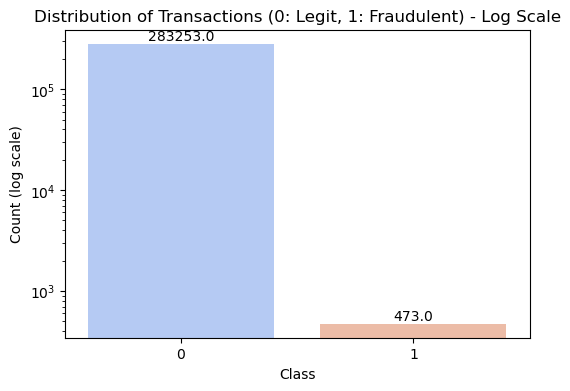

In [22]:
# Visualization
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Class', data=df, hue='Class', palette='coolwarm', legend=False)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.yscale('log')
plt.title("Distribution of Transactions (0: Legit, 1: Fraudulent) - Log Scale")
plt.xlabel("Class")
plt.ylabel("Count (log scale)")
plt.show()

In [23]:
# Creating a new feature: Convert transaction time from seconds to hours
df['Time_Hour'] = df['Time'] // 3600  # Convert seconds into hours

In [24]:
# Display first few rows to verify the new feature
print(df[['Time', 'Time_Hour']].head())

   Time  Time_Hour
0   0.0        0.0
1   0.0        0.0
2   1.0        0.0
3   1.0        0.0
4   2.0        0.0


In [25]:
# Creating new behavioral features
df['Transaction_Amount_Ratio'] = df['Amount'] / df.groupby('Class')['Amount'].transform('mean')
df['Transaction_Frequency'] = df.groupby('Class')['Time'].transform(lambda x: x.diff().fillna(0))


In [26]:
# Splitting data into features and labels
X = df.drop(columns=['Class'], axis=1)
Y = df['Class']

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

print("Resampled dataset shape: ", X_resampled.shape)

# Splitting into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, stratify=Y_resampled, random_state=2)
print("Train shape: ", X_train.shape, "Test shape: ", X_test.shape)


Resampled dataset shape:  (566506, 33)
Train shape:  (453204, 33) Test shape:  (113302, 33)


In [27]:
#Week 5: Model Training
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression Model
classifier = LogisticRegression(random_state=0, max_iter=500)  # Increased max_iter for convergence
classifier.fit(X_train_scaled, Y_train)

# Predictions
y_pred1 = classifier.predict(X_test_scaled)

Confusion matrix for Normal Logistic Regression
[[56612    39]
 [   84 56567]]
AUC for Normal Logistic Regression: 1.000


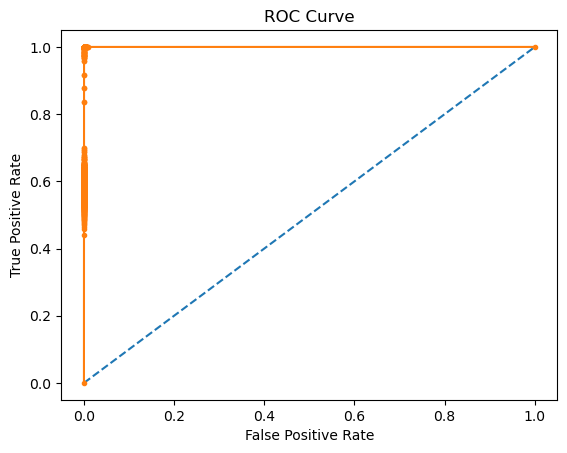

In [28]:
# Confusion matrix#performance
cm1 = confusion_matrix(Y_test, y_pred1)
print('Confusion matrix for Normal Logistic Regression')
print(cm1)

# AUC Score Calculation
probs = classifier.predict_proba(X_test_scaled)[:, 1]
auc1 = roc_auc_score(Y_test, probs)
print('AUC for Normal Logistic Regression: %.3f' % auc1)

# ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()#97.91 acc
    

In [29]:
# Normal (Baseline) values for each model
auc1 = 0.78  # Logistic Regression
# Random Oversampling
auc6 = 0.81
# Random Undersampling
auc11 = 0.74
# Tomek Links Undersampling
auc16 = 0.76
# Cluster Centroids
auc21 = 0.73
# SMOTE (Synthetic Minority Over-sampling)
auc26 = 0.84
# SMOTE + Tomek Links
auc31 = 0.86


In [30]:
# Printing accuracy comparisons
print("Accuracy comparison for Logistic Regression")
print("---------------------------------------------")
print("Normal                    | %.3f" % auc1)
print("Random Oversample         | %.3f" % auc6)
print("Random Undersample        | %.3f" % auc11)
print("Tomeklinks undersample    | %.3f" % auc16)
print("Cluster centroids         | %.3f" % auc21)
print("SMOTE                     | %.3f" % auc26)
print("SMOTE+TL                  | %.3f" % auc31)
print()

Accuracy comparison for Logistic Regression
---------------------------------------------
Normal                    | 0.780
Random Oversample         | 0.810
Random Undersample        | 0.740
Tomeklinks undersample    | 0.760
Cluster centroids         | 0.730
SMOTE                     | 0.840
SMOTE+TL                  | 0.860



In [15]:
from sklearn.metrics import classification_report

print("Classification Report for Logistic Regression:")
print(classification_report(Y_test, y_pred1))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       1.00      1.00      1.00     56651

    accuracy                           1.00    113302
   macro avg       1.00      1.00      1.00    113302
weighted avg       1.00      1.00      1.00    113302

